# Inicjalizacja danych

In [1]:
import plotly.express as px
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import t

In [2]:
sns.set_theme(style="darkgrid")

CONST_LOCATION = "location"
CONST_DISTANCE = "distance_cm"
CONST_PACKET_ERR_RATE = "packet_error_rate"
CONST_NODE_COUNT = "node_count"
CONST_PING_INTERVAL = "ping_interval"

CONST_CAT_GROUND_TRUTH = "ground_truth"
CONST_CAT_CITY = "city"
CONST_CAT_FOREST = "forest"

def compute_packet_error_rate(sent_packets_cnt, remote_received_packets_cnt):
    return (sent_packets_cnt - remote_received_packets_cnt) * 100.0 / sent_packets_cnt

def plot_catplot(data, env, title):
    data_by_location = data[data[CONST_LOCATION] == env]
    g = sns.catplot(x=CONST_DISTANCE, y=CONST_PACKET_ERR_RATE, hue=CONST_NODE_COUNT, col=CONST_PING_INTERVAL, data=data_by_location, kind="point", ci=68)
    g.figure.subplots_adjust(top=0.8)
    g.figure.suptitle(title)
    
def plot_at_ping(data, ping: int, title: str):
    data_at_ping = data[data[CONST_PING_INTERVAL] == ping]
    g = sns.catplot(x=CONST_DISTANCE, y=CONST_PACKET_ERR_RATE, hue=CONST_LOCATION, col=CONST_NODE_COUNT, kind="point", ci=68, data=data_at_ping)
    g.figure.subplots_adjust(top=0.8)
    g.figure.suptitle(title)
    
def plot_all_at_condition(data, condition, title, **params):
    data = data[condition]
    g = sns.catplot(x=CONST_DISTANCE, y=CONST_PACKET_ERR_RATE, kind="point", ci=68, data=data, **params)
    g.figure.subplots_adjust(top=0.8)
    g.figure.suptitle(title)

In [3]:
data = pd.read_csv("results.csv")

In [4]:
std_results= []
data[CONST_PACKET_ERR_RATE] = compute_packet_error_rate(data["local_sent_packets"], data["remote_received_packets"])

for node in pd.unique(data["node_count"]):
    data_node = data[data["node_count"] == node]
    for env in pd.unique(data_node["location"]):
        data_env = data_node[data_node["location"] == env]
        for interval in pd.unique(data_env["ping_interval"]):
            data_interval = data_env[data_env["ping_interval"] == interval]
            for distance in pd.unique(data_interval["distance_cm"]):
                data_distance = data_interval[data_interval["distance_cm"] == distance]
                stats = data_distance["packet_error_rate"]
                stats_mean = stats.mean()
                stats_std = stats.std()
                std_results.append({"node": node, "env": env, "interval_ms": interval, "distance_cm": distance, "mean_per": stats_mean, "std_per": stats_std})
                # print(f"node={node}@{env} {interval}ms {distance}cm mean={stats_mean} std={stats_std}")
df_results = pd.DataFrame(std_results)
df_results.tail()

,node,env,interval_ms,distance_cm,mean_per,std_per
187,2,city,2100,800,4.444444,16.850834
188,2,city,2100,10000,17.777778,32.010801
189,2,city,2100,13000,8.888889,27.666444
190,2,city,2100,16000,-4.444444,14.907120
191,2,city,2100,21000,46.666667,44.721360


In [5]:
# data_city = df_results[df_results["env"] == "city"]
# data_forest = df_results[df_results["env"] == "forest"]
# data_ground_truth = df_results[df_results["env"] == "ground_truth"]
# data_forest_n2 = data_forest[df_results["node"] == 2]

# f = sns.relplot(data=data_forest_n2.pivot("distance_cm", "interval_ms", "mean_per"), kind="line", markers=True)
# f.set_titles("Forest, 2 nodes")
# import matplotlib.pyplot as plt
# g = sns.FacetGrid(data_forest_n2, col="interval_ms")
# g.map(plt.errorbar, "distance_cm", "mean_per", "std_per", marker="o")

# sns.catplot(x="distance_cm", y="mean_per", hue="interval_ms", data=data_forest_n2, col="interval_ms", kind="point")
# sns.lineplot(x="distance_cm", y="mean_per", hue="interval_ms", data=data_forest_n2, markers=True)

# Przegląd danych względem lokalizacji

## Struktura danych

In [6]:
data.tail()

,node_count,ping_interval,distance_cm,local_sent_packets,remote_received_packets,location,packet_error_rate
955,2,2100,21000,9,9,city,0.000000
956,2,2100,21000,9,1,city,88.888889
957,2,2100,21000,9,0,city,100.000000
958,2,2100,21000,9,7,city,22.222222
959,2,2100,21000,9,7,city,22.222222


## Pomiary - miasto

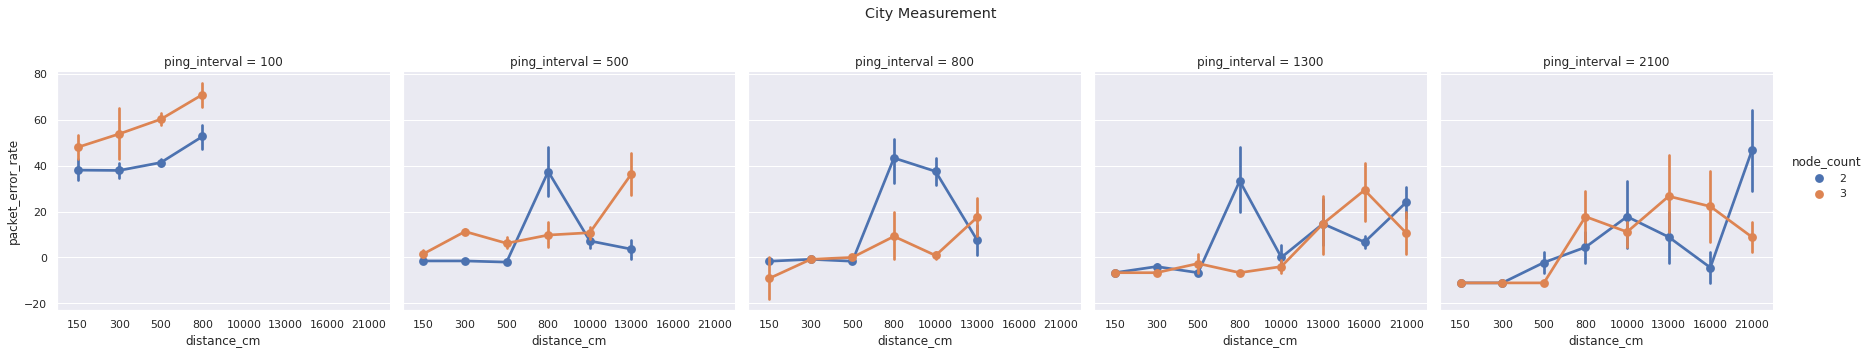

In [7]:
plot_catplot(data, "city", "City Measurement")

## Pomiary - las

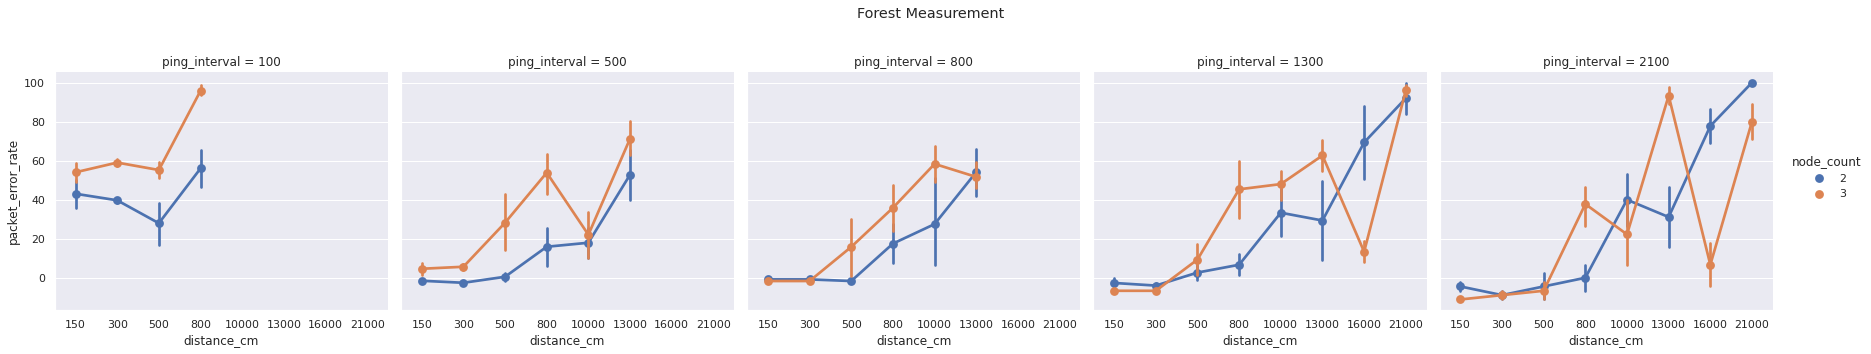

In [8]:
plot_catplot(data, "forest", "Forest Measurement")

# Przegląd danych - porównanie ilości węzłów dla PER względem czasu pingowania

## Ping = 100ms

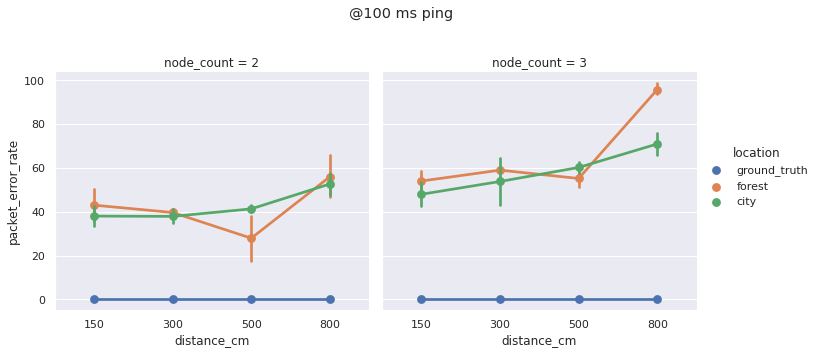

In [9]:
plot_at_ping(data, 100, "@100 ms ping")

Pomimo bliskiej wzajemnej obecności węzłów, dostrzega się błędy PER. Wynikają one nie tyle z samej właściwości BLE, co z samej stosu BLE Mesh wykorzystywanego do badań. Przy dużej ilości zdarzeń, mikrokontroler traci stabilność, gubiąc komunikaty/przepełniając bufory. Mikrokontroler w tej sytacji wymagał również restartów.

## Ping = 500ms

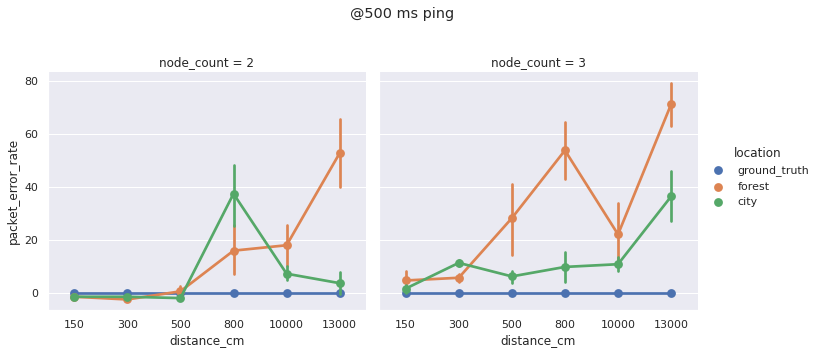

In [10]:
plot_at_ping(data, 500, "@500 ms ping")

## Ping = 800ms

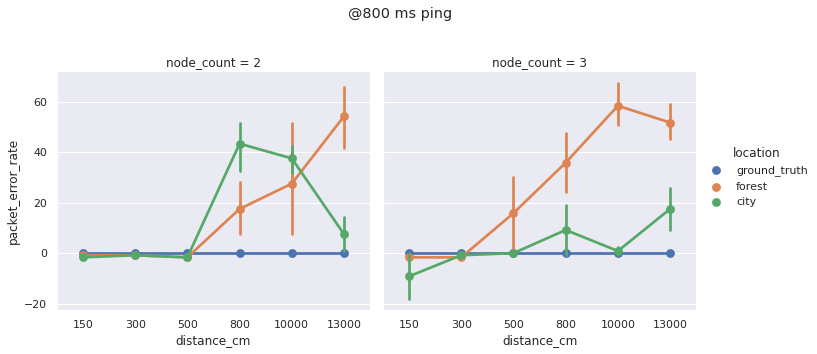

In [11]:
plot_at_ping(data, 800, "@800 ms ping")

## Ping = 1300ms

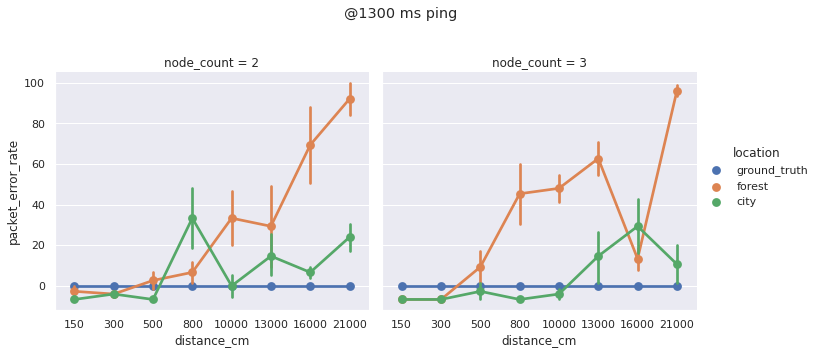

In [12]:
plot_at_ping(data, 1300, "@1300 ms ping")

## Ping = 2100ms

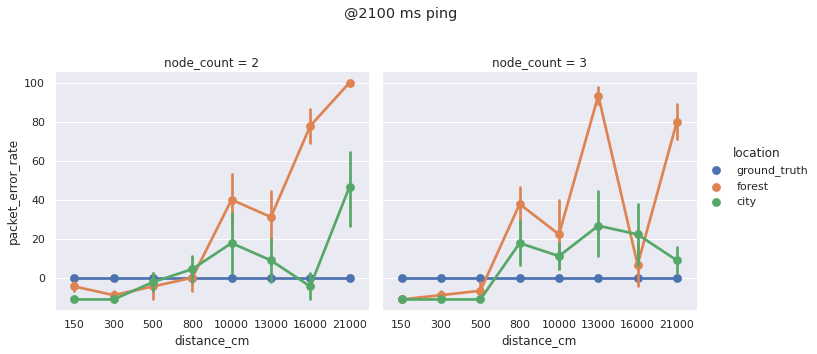

In [13]:
plot_at_ping(data, 2100, "@2100 ms ping")

# Analiza danych

## Zależność Packet Error Rate względem częstości zapytań

### ≤ 100ms

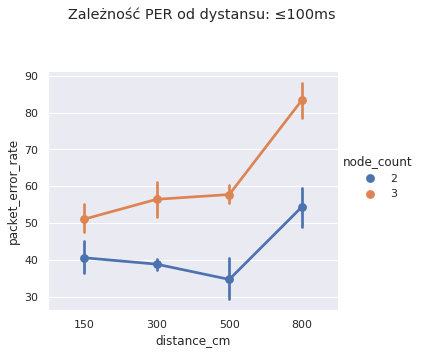

In [14]:
plot_all_at_condition(data, ((data[CONST_PING_INTERVAL] == 100) & (data[CONST_LOCATION] != CONST_CAT_GROUND_TRUTH)), "Zależność PER od dystansu: ≤100ms", hue=CONST_NODE_COUNT)

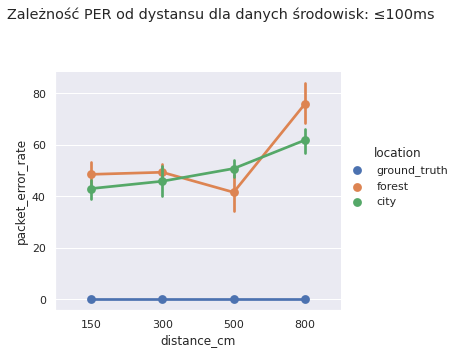

In [15]:
plot_all_at_condition(data, data[CONST_PING_INTERVAL] == 100, "Zależność PER od dystansu dla danych środowisk: ≤100ms", hue=CONST_LOCATION)

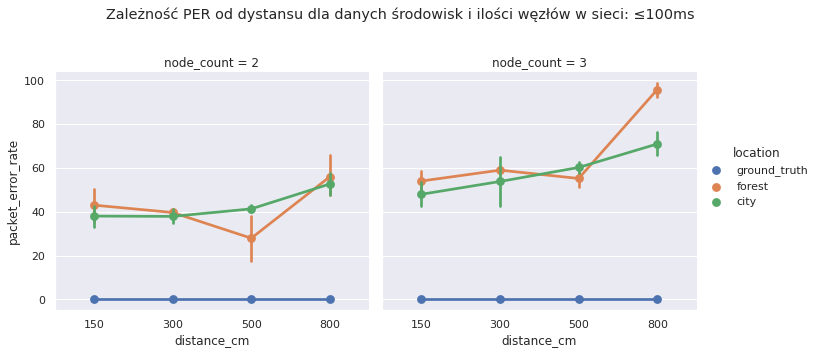

In [20]:
plot_all_at_condition(data, data[CONST_PING_INTERVAL] == 100, "Zależność PER od dystansu dla danych środowisk i ilości węzłów w sieci: ≤100ms", hue=CONST_LOCATION, col=CONST_NODE_COUNT)

### >100ms

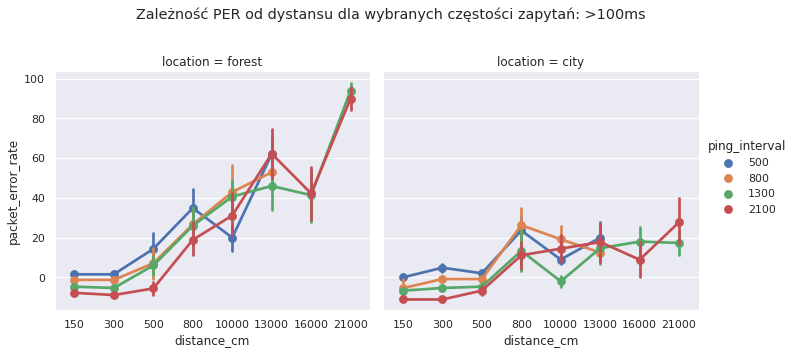

In [35]:
plot_all_at_condition(data, ((data[CONST_PING_INTERVAL] > 100)&(data[CONST_LOCATION] != CONST_CAT_GROUND_TRUTH)), "Zależność PER od dystansu dla wybranych częstości zapytań: >100ms", hue=CONST_PING_INTERVAL, col=CONST_LOCATION, dodge=False)

In [ ]:
Może zbadanie korelacji pomiędzy różnicami w PER? Zdaje się, że zmienna PING INTERVAL nie wpływa na PER

## Zależność Packet Error Rate względem odległości między węzłami

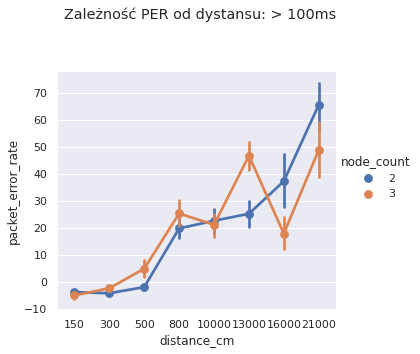

In [17]:
plot_all_at_condition(data, ((data[CONST_PING_INTERVAL] > 100) & (data[CONST_LOCATION] != CONST_CAT_GROUND_TRUTH)), "Zależność PER od dystansu: > 100ms", hue=CONST_NODE_COUNT)

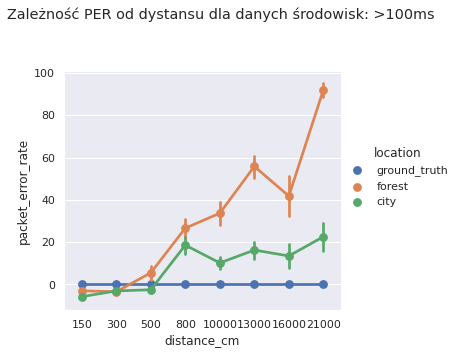

In [18]:
plot_all_at_condition(data, data[CONST_PING_INTERVAL] > 100, "Zależność PER od dystansu dla danych środowisk: >100ms", hue=CONST_LOCATION)

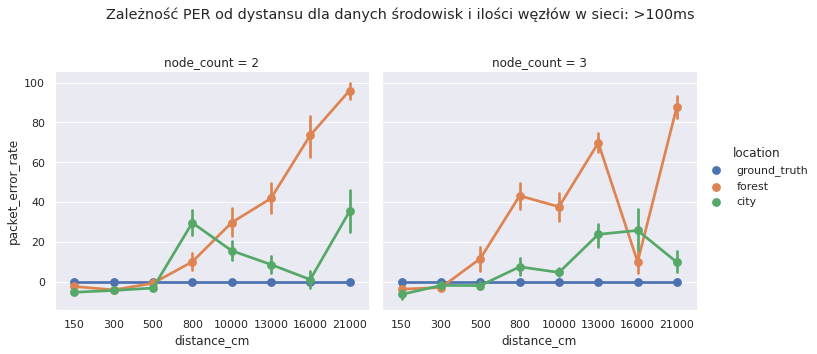

In [36]:
plot_all_at_condition(data, data[CONST_PING_INTERVAL] > 100, "Zależność PER od dystansu dla danych środowisk i ilości węzłów w sieci: >100ms", hue=CONST_LOCATION, col=CONST_NODE_COUNT)

In [41]:
df_results.corr()

,node,interval_ms,distance_cm,mean_per,std_per
node,1.000000e+00,4.079520e-16,9.207782e-17,0.058718,-0.013056
interval_ms,4.079520e-16,1.000000e+00,3.241180e-01,-0.161852,0.097652
distance_cm,9.207782e-17,3.241180e-01,1.000000e+00,0.306864,0.305297
mean_per,5.871800e-02,-1.618522e-01,3.068641e-01,1.000000,0.518649
std_per,-1.305596e-02,9.765163e-02,3.052973e-01,0.518649,1.000000
